In [1]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns
from scipy import interp

from collections import Counter
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score 
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

import pandas_profiling as pp
from pycaret.classification import *

In [2]:
# Load dataset
bm = pd.read_csv("bank_marketing_scikit_label_dataset.csv")

In [3]:
# Change the unit of "duration" from seconds to minutes
bm['duration'] = bm['duration'].apply(lambda n: n / 60).round(2)

# Drop rows with "duration" < 5s because those interactions do not contribute much
duration_condition = (bm['duration'] < 5 / 60)
bm = bm.drop(bm[duration_condition].index, axis=0, inplace=False)

# Drop rows with "job" or "education" == "unknown"
job_condition = (bm['job'] == 11.0)
bm = bm.drop(bm[job_condition].index, axis=0, inplace=False)
edu_condition = (bm['education'] == 3.0)
bm = bm.drop(bm[edu_condition].index, axis=0, inplace=False)

In [4]:
# Change the types of the target classifier columns

bm["response"] = bm['y'].astype('category')
bm["response"].describe()
bm = bm.drop('y', axis=1)

bm["credit_default"] = bm['default'].astype('category')
bm["credit_default"].describe()
bm = bm.drop('default', axis=1)

bm["personal_loan"] = bm['loan'].astype('category')
bm["personal_loan"].describe()
bm = bm.drop('loan', axis=1)

In [5]:
bm.head(5)

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,response,credit_default,personal_loan
0,30.0,10.0,1.0,0.0,1787.0,0.0,0.0,19.0,10.0,1.32,1.0,-1.0,0.0,3.0,0.0,0.0,0.0
1,33.0,7.0,1.0,1.0,4789.0,1.0,0.0,11.0,8.0,3.67,1.0,339.0,4.0,0.0,0.0,0.0,1.0
2,35.0,4.0,2.0,2.0,1350.0,1.0,0.0,16.0,0.0,3.08,1.0,330.0,1.0,0.0,0.0,0.0,0.0
3,30.0,4.0,1.0,2.0,1476.0,1.0,2.0,3.0,6.0,3.32,4.0,-1.0,0.0,3.0,0.0,0.0,1.0
4,59.0,1.0,1.0,1.0,0.0,1.0,2.0,5.0,8.0,3.77,1.0,-1.0,0.0,3.0,0.0,0.0,0.0


In [6]:
bm["month"].value_counts()

8.0     1336
5.0      675
1.0      611
6.0      491
9.0      375
0.0      286
3.0      212
4.0      134
10.0      72
7.0       46
11.0      45
2.0       18
Name: month, dtype: int64

### Check Imbalance Issues

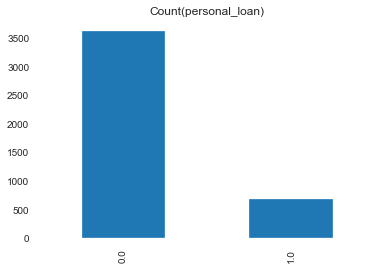

In [7]:
# Check the imbalance problem in "loan"
bm.personal_loan.value_counts().plot(kind='bar', title='Count(personal_loan)')

From the above bar graph of the "personal_loan" column, the "1" or "yes" class is again significantly less than the "0" or "no" class at a ratio of approximately 3:16.

### Testing Stratified Sampling

To address and try to solve the class imbalance issue, we first test the effectiveness of using stratified sampling alone. The testing algorithm in this case is the Gaussian NB model.

Before the actual testing, we need to set up the different sets of X (predictor sets) and y (target) since our three research questions are targeting different predictors.

In [8]:
# Set up X and y for the third question
X3 = bm.drop((['personal_loan']), axis=1)
y3 = bm['personal_loan']
X3 = X3.astype('int')
y3 = y3.astype('category')

In [9]:
# Specify metrics used for performance evaluation
metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']

scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV'])

# Set up a 10-fold CV to compare with the stratified approach
cv = KFold(n_splits=10)
scv = StratifiedKFold(n_splits=10)
clf = GaussianNB() # trial run with basic algorithm

In [10]:
# Trial testing performance comparison for "personal_loan" target
for metric in metric_names:
    score1 = cross_val_score(clf, X3, y3, scoring=metric, cv=cv).mean()
    score2 = cross_val_score(clf, X3, y3, scoring=metric, cv=scv).mean()
    scores_df.loc[metric] = [score1, score2]

scores_df

,Random-CV,Stratified-CV
f1,0.10991,0.104357
roc_auc,0.595736,0.595131
average_precision,0.221369,0.218682
accuracy,0.821673,0.821436
precision,0.265115,0.255197
recall,0.070723,0.0661125


### Resampling

#### Setting Up Before Oversampling

Here we set up the stratified 10-fold CV and a list of models (not yet tuned) that we will use for testing the effectiveness of several oversampling methods.

In [11]:
RANSTA = 50

scv = StratifiedKFold(n_splits=10, random_state=RANSTA, shuffle=True)

models = []
models.append((LogisticRegression(solver='lbfgs', max_iter=7000)))
models.append((KNeighborsClassifier(n_neighbors=5)))
models.append((DecisionTreeClassifier()))
models.append((RandomForestClassifier()))
models.append((GaussianNB()))
models.append((SVC()))

To make the oversampling method testing process more succinct and easy to read, we first create a helper function using for loops to evaluate the list of models and print out the metrics table. 

In [12]:
def oversampleReport(models, metric_names, X_resampled, y_resampled):
  """
  Print model and metrics report table
  """
  scores_cols = ['LR', 'KNN', 'DT', 'RF', 'NB', 'SVC']
  scores = pd.DataFrame(index=metric_names, columns=scores_cols)

  for key, model in enumerate(models):
      for metric in metric_names:
          score = cross_val_score(model, X_resampled, y_resampled, scoring=metric, cv=scv).mean()
          scores.at[metric, scores_cols[key]] = score 
  
  return scores

#### Oversampling Only (SMOTE and ADASYN)

To perform oversampling, we start by using one of the most known techniques: SMOTE (Synthetic Minority Over-sampling Technique). This method create synthetic datapoints in the following steps:

1. For each real/existing data point, seek for its K nearest neighbors (default K = 5)
2. Randomly choose one of the neighbors and build a vector between the two points
3. Multiplying the vector with a random number between one and zero to get the new data point.

The Adaptive Synthetic (ADASYN) is an adaptive approach of SMOTE.

SMOTE: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-106

ADASYN: https://www.researchgate.net/publication/224330873_ADASYN_Adaptive_Synthetic_Sampling_Approach_for_Imbalanced_Learning

##### SMOTE

In [13]:
# SMOTE oversampling for the third question
smote = SMOTE(random_state=RANSTA)
X_resampled_s3, y_resampled_s3 = smote.fit_resample(X3, y3)

# Check the number of observations in each class after resampling
print(sorted(Counter(y_resampled_s3).items()))

oversampleReport(models, metric_names, X_resampled_s3, y_resampled_s3)

[(0.0, 3620), (1.0, 3620)]


,LR,KNN,DT,RF,NB,SVC
f1,0.713422,0.775275,0.79285,0.864333,0.702608,0.613478
roc_auc,0.772749,0.835761,0.788398,0.929672,0.765676,0.586602
average_precision,0.751462,0.786556,0.718392,0.938176,0.777011,0.577055
accuracy,0.708011,0.739365,0.787983,0.867956,0.628729,0.55442
precision,0.700359,0.682063,0.773976,0.879873,0.586123,0.541643
recall,0.727348,0.898343,0.820166,0.848619,0.877072,0.707459


##### ADASYN

In [14]:
# ADASYN oversampling for the third question
ada = ADASYN(random_state=RANSTA)
X_resampled_a3, y_resampled_a3 = ada.fit_resample(X3, y3)

# Check the number of observations in each class after resampling
print(sorted(Counter(y_resampled_a3).items()))

oversampleReport(models, metric_names, X_resampled_a3, y_resampled_a3)

[(0.0, 3620), (1.0, 3504)]


,LR,KNN,DT,RF,NB,SVC
f1,0.702249,0.773358,0.781872,0.859182,0.691936,0.597785
roc_auc,0.766606,0.822829,0.777849,0.928129,0.761664,0.5778
average_precision,0.737697,0.760022,0.710709,0.933247,0.768769,0.563376
accuracy,0.701991,0.738342,0.779481,0.865804,0.617489,0.552643
precision,0.690288,0.674278,0.761603,0.877629,0.573133,0.535753
recall,0.715185,0.906964,0.797092,0.844475,0.873289,0.676379


#### Combination of Over- and Undersampling (SMOTETomek and SMOTEENN)

In addition to using oversampling by itself, we also decided to test the combination methods which consist of both oversampling and undersampling techniques. Since SMOTE generates samples without regards to the underlying distribution, it might create some noisy samples where the two classes have no clear distinction. In this case, implementing undersampling algorithms such as Tomek's link and Edited Nearest Neighbors can be good for cleaning noisy samples.

Tomek's link: https://dl.acm.org/doi/10.1145/1007730.1007735

ENN: https://pdfs.semanticscholar.org/c1a9/5197e15fa99f55cd0cb2ee14d2f02699a919.pdf

The imbalanced-learn library has implemented these two algorithms in combination with SMOTE to create two useful classes: SMOTETomek and SMOTEENN.

##### SMOTETomek

In [15]:
# SMOTETomek combo for the third question
smo_tmk = SMOTETomek(random_state=RANSTA)
X_resampled_st3, y_resampled_st3 = smo_tmk.fit_resample(X3, y3)

# Check the number of observations in each class after resampling
print(sorted(Counter(y_resampled_st3).items()))

oversampleReport(models, metric_names, X_resampled_st3, y_resampled_st3)

[(0.0, 3463), (1.0, 3463)]


,LR,KNN,DT,RF,NB,SVC
f1,0.71825,0.786258,0.791631,0.863176,0.702863,0.61827
roc_auc,0.776686,0.848856,0.786889,0.932443,0.76665,0.591989
average_precision,0.755882,0.79587,0.724595,0.938945,0.777229,0.58078
accuracy,0.711951,0.750364,0.789203,0.867887,0.628073,0.558483
precision,0.703346,0.687789,0.775958,0.879384,0.585214,0.544457
recall,0.734335,0.918001,0.814326,0.848681,0.879878,0.715588


##### SMOTEENN

In [16]:
# SMOTE-ENN combo for the third question
smo_enn = SMOTEENN(random_state=RANSTA)
X_resampled_se3, y_resampled_se3 = smo_enn.fit_resample(X3, y3)

# Check the number of observations in each class after resampling
print(sorted(Counter(y_resampled_se3).items()))

oversampleReport(models, metric_names, X_resampled_se3, y_resampled_se3)

[(0.0, 1429), (1.0, 2693)]


,LR,KNN,DT,RF,NB,SVC
f1,0.840403,0.936987,0.862108,0.911743,0.803667,0.796893
roc_auc,0.819538,0.967341,0.788938,0.949775,0.803726,0.707788
average_precision,0.883076,0.970038,0.826214,0.970967,0.879038,0.812956
accuracy,0.774869,0.913387,0.818284,0.880638,0.718095,0.677584
precision,0.782673,0.894129,0.849553,0.894221,0.737317,0.677194
recall,0.907553,0.984416,0.879719,0.927975,0.883421,0.968817


### Feature Selection

#### Train-Test Split (Using Resampled Data)

In [17]:
# train-test 80/20 split for "personal_loan" classification
X3_train, X3_test, y3_train, y3_test = train_test_split(X_resampled_se3, y_resampled_se3, test_size=0.2, random_state=RANSTA)

Optimal number of features : 16
Best features : ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'response', 'credit_default']


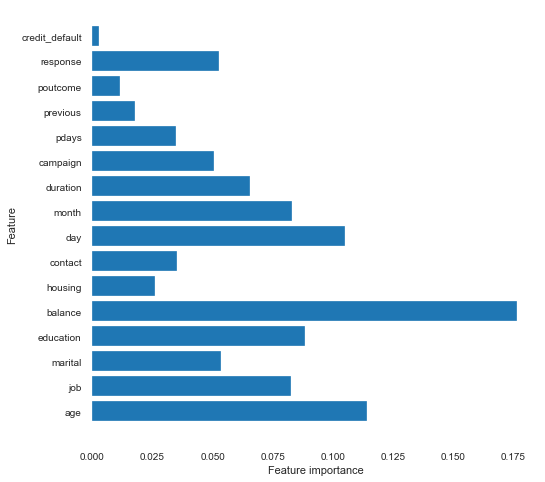

In [18]:
cv_estimator = RandomForestClassifier(n_jobs=4, random_state=RANSTA)
cv_estimator.fit(X3_train, y3_train)
cv_selector = RFECV(cv_estimator,cv= 10, step=1,scoring='accuracy')
cv_selector = cv_selector.fit(X3_train, y3_train)
rfecv_mask = cv_selector.get_support()

rfecv_features = []

for bool, feature in zip(rfecv_mask, X3_train.columns):
    if bool:
        rfecv_features.append(feature)

print('Optimal number of features :', cv_selector.n_features_)
print('Best features :', rfecv_features)
n_features = X3_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X3_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

### Further Modeling

In [19]:
def hyperTuning(model, param_grid, X_train, y_train, X_test, y_test):
  """
  @params model: ML model, scikit-learn object
  @params param_grid: the hyperparameter for the model
  @return best training model (cross-validated)
  """
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10, scoring='accuracy',error_score=0)
  grid_result = grid_search.fit(X_train, y_train)
  # summarize results
  
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

  print("-----------------------------------------------------------")
  print()
  print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  print()

  y_true, y_pred = y_test, grid_result.predict(X_test)
  print("Detailed classification report:")
  print()
  print(classification_report(y_true, y_pred))

### ROC Curve Before Tuning

C:\Users\devil\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


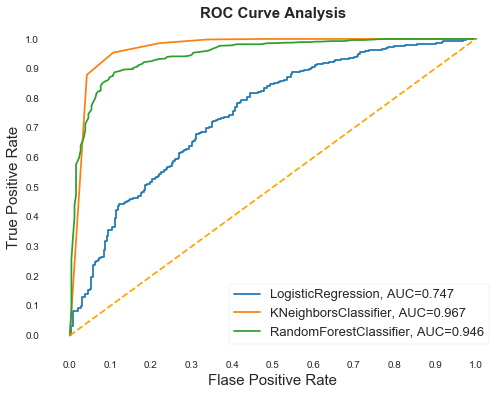

In [20]:
classifiers = [LogisticRegression(random_state=RANSTA), 
               KNeighborsClassifier(), 
               RandomForestClassifier(random_state=RANSTA)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X3_train, y3_train)
    yproba = model.predict_proba(X3_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y3_test, yproba)
    auc = roc_auc_score(y3_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

#### KNN

In [21]:
hyperTuning(KNeighborsClassifier(), 
            dict(leaf_size=list(range(1,50)), n_neighbors=list(range(1,30)), p=[1,2]),
            X3_train, y3_train, X3_test, y3_test)

0.959960 (0.009485) with: {'leaf_size': 1, 'n_neighbors': 1, 'p': 1}
0.969061 (0.008879) with: {'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
0.961779 (0.007838) with: {'leaf_size': 1, 'n_neighbors': 2, 'p': 1}
0.962685 (0.010542) with: {'leaf_size': 1, 'n_neighbors': 2, 'p': 2}
0.932967 (0.014014) with: {'leaf_size': 1, 'n_neighbors': 3, 'p': 1}
0.931752 (0.009250) with: {'leaf_size': 1, 'n_neighbors': 3, 'p': 2}
0.929326 (0.010003) with: {'leaf_size': 1, 'n_neighbors': 4, 'p': 1}
0.926899 (0.008114) with: {'leaf_size': 1, 'n_neighbors': 4, 'p': 2}
0.888376 (0.016547) with: {'leaf_size': 1, 'n_neighbors': 5, 'p': 1}
0.888375 (0.015287) with: {'leaf_size': 1, 'n_neighbors': 5, 'p': 2}
0.890498 (0.016428) with: {'leaf_size': 1, 'n_neighbors': 6, 'p': 1}
0.887163 (0.015216) with: {'leaf_size': 1, 'n_neighbors': 6, 'p': 2}
0.862895 (0.019252) with: {'leaf_size': 1, 'n_neighbors': 7, 'p': 1}
0.866845 (0.016327) with: {'leaf_size': 1, 'n_neighbors': 7, 'p': 2}
0.862896 (0.018574) with: {'leaf_s

#### Logistic Regression

In [22]:
hyperTuning(LogisticRegression(), 
            dict(C = np.logspace(-4, 4, 20), max_iter = [1000, 2500, 5000]),
            X3_train, y3_train, X3_test, y3_test)

0.680617 (0.018113) with: {'C': 0.0001, 'max_iter': 1000}
0.680617 (0.018113) with: {'C': 0.0001, 'max_iter': 2500}
0.680617 (0.018113) with: {'C': 0.0001, 'max_iter': 5000}
0.687290 (0.019353) with: {'C': 0.00026366508987303583, 'max_iter': 1000}
0.687290 (0.019353) with: {'C': 0.00026366508987303583, 'max_iter': 2500}
0.687290 (0.019353) with: {'C': 0.00026366508987303583, 'max_iter': 5000}
0.696390 (0.018516) with: {'C': 0.0006951927961775605, 'max_iter': 1000}
0.696390 (0.018516) with: {'C': 0.0006951927961775605, 'max_iter': 2500}
0.696390 (0.018516) with: {'C': 0.0006951927961775605, 'max_iter': 5000}
0.711246 (0.017518) with: {'C': 0.0018329807108324356, 'max_iter': 1000}
0.711854 (0.017556) with: {'C': 0.0018329807108324356, 'max_iter': 2500}
0.711854 (0.017556) with: {'C': 0.0018329807108324356, 'max_iter': 5000}
0.729440 (0.015873) with: {'C': 0.004832930238571752, 'max_iter': 1000}
0.728230 (0.021847) with: {'C': 0.004832930238571752, 'max_iter': 2500}
0.728230 (0.021847) wi

#### Random Forest

In [23]:
hyperTuning(RandomForestClassifier(), dict(n_estimators = [10, 100, 1000], max_features = ['sqrt', 'log2']),
            X3_train, y3_train, X3_test, y3_test)

0.863814 (0.023121) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.875945 (0.016423) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.874430 (0.017487) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.863813 (0.021441) with: {'max_features': 'log2', 'n_estimators': 10}
0.869571 (0.021017) with: {'max_features': 'log2', 'n_estimators': 100}
0.874126 (0.021292) with: {'max_features': 'log2', 'n_estimators': 1000}
-----------------------------------------------------------

Best Accuracy: 0.875945 using {'max_features': 'sqrt', 'n_estimators': 100}

Detailed classification report:

              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82       263
         1.0       0.91      0.93      0.92       562

    accuracy                           0.89       825
   macro avg       0.87      0.87      0.87       825
weighted avg       0.89      0.89      0.89       825



### ROC Curve After Tuning

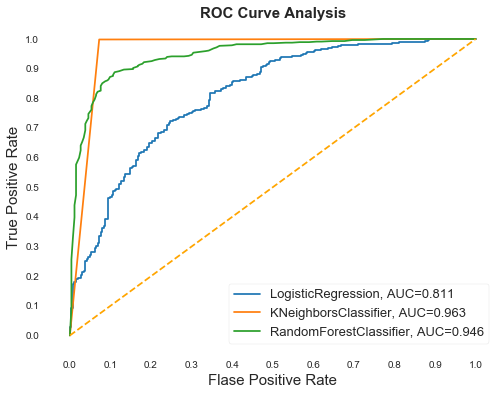

In [25]:
classifiers = [LogisticRegression(C=29.763514416313132, max_iter=5000, random_state=RANSTA), 
               KNeighborsClassifier(leaf_size=47, n_neighbors=1, p=2), 
               RandomForestClassifier(max_features='sqrt', n_estimators=100, random_state=RANSTA)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X3_train, y3_train)
    yproba = model.predict_proba(X3_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y3_test, yproba)
    auc = roc_auc_score(y3_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()